# OpenAI Gym API
### 2022/05/10, AJ Zerouali


## Intro

This notebook summarizes notes on Gym. The objective is to understand what the available functionalities are, and see how

### References
My references for this notebook are:
* Phil Tabor's free Youtube lectures on DQN.

    Playlist: https://www.youtube.com/watch?v=4GhH3d9NsIc&list=PL-9x0_FO_lgn8hXJk5uRv1bO36xyTx00f&ab_channel=MachineLearningwithPhil,
    
    GitHub repo at: https://github.com/philtabor/Youtube-Code-Repository/tree/master/ReinforcementLearning/DeepQLearning.
    
    
* Stefan Jansen's "Machine Learning for Algorithmic Trading" book. TensorFlow is introduced in Ch. 17 - Deep learning for trading; OpenAI and DQN are discussed in Ch. 22 - Deep RL.

    Github DQN example: https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/22_deep_reinforcement_learning/03_lunar_lander_deep_q_learning.ipynb
    
* Maxim Lapan's "Deep Reinforcement Learning Hands-On". Chapter 2 has a good description of the OpenAI Gym API (better than Ravichandiran's), explains the software architecture of the Environment and Space classes of this package, and briefly discusses wrappers at the end of the chapter. The deep networks are implemented with PyTorch however.

* Sudharsan Ravichandiran's "Deep Reinforcement Learning with Python". This book is very similar in terms of contents and scope to Lapan's, but uses TensorFlow 2 and Keras for the implementation of deep networks. Chapter 8 in particular gives a rather detailed primer on TensorFLow, and does a good job of including API details that are absent from all courses and tutorials I've seen previously.

### Fundamental imports

What we're importing and why. Specific references to sections.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym


In [2]:
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 1) The agent and the environment

The following is from "The anatomy of the agent" in Lapan's book. At a high level, let's discuss the contents of an *Environment* class, an *Agent* class, and how they're connected in a *Main* file. This will serve as a prototype for the 

1) The **Environment** is typically implemented like so:

            class Environment:
            
                # Constructor
                def __init__(self):
                    self.steps_left = 10
            
                # Return current agent state in env.
                def get_observation(self):
                    ...
                    return List[float]
                
                # Return admissible actions
                def get_actions(self):
                    ...
                    return List[int]
                
                # Check if end of episode
                def is_done(self):
                    ...
                    return bool
                
                # Execute agent's action, return reward
                def action(self, action_label):
                    if self.is_done():
                        print("Game over")
                    self.steps_left -= 1
                    reward = R[old_state, action_label, new_state] # Generic code
                    return reward
                    
The main remark here is that the agent's **current state**, **admissible actions**, **rewards** and **end of episode** are handled by the environment class. Although it is not spelled-out explicitly, the *Environment.get_actions()* method returns the actions accessible to the agent in its *current state*. On a personal note, I would've written *Environment.get_state()* instead of *Environment.get_observation()*.

(This design isn't very efficient if we plan on simulating more than one agent in the same environment. Lapan doesn't say much about attributes.)

2) The **Agent** class on the other hand contains only 2 methods:

            class Agent:
                
                # Constructor
                def __init__(self):
                    self.total_reward = 0.0
                    
                # Take one step in episode
                def step(self, env: Environment):
                    
                    # Setup temp variables
                    current_obs = env.get_observation()
                    adm_actions = env.get_actions()
                    
                    # Take random action and get its reward
                    reward = env.action(np.random.choice(adm_actions))
                    self.total_reward += reward
                    
The main attribute of the agent is its cumulative return, which is initialized in the constructor. The *Agent.step(env)* method is the foundation of the design. First it collects the relevant parameters from the environment (current state and possible actions), and once an action is executed using *Environment.action(action_label)*, the agent receives the reward from the environment and updates its cumulative return (Lapan doesn't specify how the environment attributes are updated at this point).

3) Lastly, the *main* should instantiate the two classes above, and run episode within a loop:

        if __name__ == '__main__':
        
            # Create env. and agent
            env = Environment()
            agent = Agent()
            
            # Run one episode
            while not env.is_done():
                agent.step(env)
                
            # Print cumul. returns:
            print(f"Agent cumulative return = {agent.total_rewards}")

## 2) Open AI Gym - Actions, State Spaces and Environments

Based on the previous section, we now turn to Gym's main components. Again from a high level, every Gym environment has:
* A set of admissible actions to be executed by the agent.
* The shape and boundaries of the observations passed to the agent by the environment.
The central class we discuss below is *Env*, which is essentially the core of this library. As in the pseudocode above, it has two main methods:
* ***Env.step(action)***, to execute a given action.
* ***Env.reset()***, to return the agent to its initial state in the environment.

We will start by discussing the *Space* class, which is used to describe actions and *observations* (this is how they call observed states). Additional information on the classes discussed below can be found at Gym's official documentation page: https://www.gymlibrary.ml/ (note that https://gym.openai.com/docs/ is deprecated).

### a) The *Space* class

The action space and the state space are represented by an abstract class *Space* in Gym, whose two most relevant methods are:
* ***sample()***, which returns a random sample from the space. This method is typically called when performing actions.
* ***contains(x)***, which checks whether the state $x$ belongs to the space's domain.

These methods are abstract and reimplemented in any subclass of *Space*. The class diagram below shows 3 of the subclasses implemented in Gym:

<img src = "Figures/Gym_Space_Class_Diag.png" height= 340 width = 340>

<img src = "Figures/Gym_Space_Class_Diag.png">

**describe the 3 classes here**
* ***Discrete:*** This space class models finite spaces, with elements labelled from $0$ to $n$. The values assigned to each label are described in the environment subclass (see example below).

* ***Box:*** Boxes represent $n$-dimensional tensor of rational numbers in intervals $[x_\min, x_\max]$, and have a *dtype* parameter in their constructor. The first use of this class is to define the bounds of a rectangular region that will be discretized in the background, and the *dtype* specifies the desired accuracy. There is also a *shape* argument in the constructor, which for example is used when the states are represented by screenshots of a game (think of the Atari environments). In the case of images of size 210x160 pixels, one calls

            Box(low = 0, high=255, size = (210, 160, 3)),
            
    where 3 stands for the RGB channels.
    
* ***Tuple:*** Some spaces could be of various complexity, such as having discrete and continuous components. The *Tuple* class allows to define such spaces in a nested way, by combining the previous classes for instance (see example of car controls on p.33).

Now we come to an important point: Every *Env* of Gym has two instances of space among its attributes, *action_space* and *observation_space*.


### Example: Frozen Lake (ToyText)

It is worth looking at a concrete example now. To see what how state space and action spaces are implemented in the Frozen lake environment, we can look at its module in *gym.envs.toy_text.frozen_lake*

In [2]:
flake = gym.make('FrozenLake-v1')
obs, info = flake.reset(return_info = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
help(gym.envs.toy_text.frozen_lake)

Help on module gym.envs.toy_text.frozen_lake in gym.envs.toy_text:

NAME
    gym.envs.toy_text.frozen_lake

CLASSES
    gym.core.Env(typing.Generic)
        FrozenLakeEnv
    
    class FrozenLakeEnv(gym.core.Env)
     |  FrozenLakeEnv(*args, **kwds)
     |  
     |  Frozen lake involves crossing a frozen lake from Start(S) to Goal(G) without falling into any Holes(H) by walking over
     |  the Frozen(F) lake. The agent may not always move in the intended direction due to the slippery nature of the frozen lake.
     |  
     |  
     |  ### Action Space
     |  The agent takes a 1-element vector for actions.
     |  The action space is `(dir)`, where `dir` decides direction to move in which can be:
     |  
     |  - 0: LEFT
     |  - 1: DOWN
     |  - 2: RIGHT
     |  - 3: UP
     |  
     |  ### Observation Space
     |  The observation is a value representing the agent's current position as
     |  current_row * nrows + current_col (where both the row and col start at 0).
     |  F

In [5]:
help(flake)

Help on TimeLimit in module gym.wrappers.time_limit object:

class TimeLimit(gym.core.Wrapper)
 |  TimeLimit(*args, **kwds)
 |  
 |  Wraps the environment to allow a modular transformation.
 |  
 |  This class is the base class for all wrappers. The subclass could override
 |  some methods to change the behavior of the original environment without touching the
 |  original code.
 |  
 |  .. note::
 |  
 |      Don't forget to call ``super().__init__(env)`` if the subclass overrides :meth:`__init__`.
 |  
 |  Method resolution order:
 |      TimeLimit
 |      gym.core.Wrapper
 |      gym.core.Env
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, env, max_episode_steps=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  reset(self, **kwargs)
 |      Resets the environment to an initial state and returns an initial
 |      observation.
 |      
 |      This method should also reset the environment's rand

In [7]:
help(flake.step)

Help on method step in module gym.wrappers.time_limit:

step(action) method of gym.wrappers.time_limit.TimeLimit instance
    Run one timestep of the environment's dynamics. When end of
    episode is reached, you are responsible for calling `reset()`
    to reset this environment's state.
    
    Accepts an action and returns a tuple (observation, reward, done, info).
    
    Args:
        action (object): an action provided by the agent
    
    Returns:
        observation (object): agent's observation of the current environment
        reward (float) : amount of reward returned after previous action
        done (bool): whether the episode has ended, in which case further step() calls will return undefined results
        info (dict): contains auxiliary diagnostic information (helpful for debugging, logging, and sometimes learning)



There are 3 shortcomings here:
- When calling *gym.make('Env_name')*, Gym actually calls a wrapper to create the environment, and not exactly the class itself. Using help('env') will just return info on the TimeLimit (wrapper) class.
- In Frozen Lake For example, the hole terminal states have a reward of 0, not -1 as in GridWorld. Modifying the available environment requires more care (**Comment:** I don't know of an easy and straightforward way of doing that, but I think it's possible).
- Gym doesn't readily give access to the possible actions in a given state or the rewards corresponding to a new state. The developers somehow obfuscate these attributes.

### b) The *Env* class

Now we look at the *gym.Env* class in more detail:

* ***action_space:*** This attribute encodes the actions of the actions in the environment, andd is typically a subclass of *Space*.
* ***observation_space:*** Same as above, but this attribute encodes the states.
* ***reset():*** This method puts resets the agent back to the initial state in the environment. It should always be called after building the *Env* object. It returns the initial observation vector.
* ***step():*** This method is used as follows:
        
        next_state, reward, done, info = env.step(action)
    Obviously, this is one of the crucial methods of *Env*. The input is the action of the agent, and the output consists of the new state (NumPy array), the corresponding reward (float), and the boolean *done* saying whether or not *next_state* is terminal. The *info* output contains information relevant for debugging and learning (**Comment:** Should I say more about this point).
        
* ***render():*** This method allows to visualize the evolution of the agent. It calls the PyGame package which in turn calls upon some low-level C features (one of the prerequisite packages of Gym is *SWIG*, which calls a C++ compiler). One of its arguments is *mode*, which is set to *'human'* by default. Once done with this method, one calls *Env.close()* to shutdown PyGame (in Windows is pops-up as a new window).

The environments available in Gym are organized into some of the following packages:
- Toy Text: GridWorld text environments such as FrozenLake. The new versions aren't textboxes anymore.
- Classic Control: These are toy model classic control and RL problems. Mostly used for demonstrations and benchmarking.
- Box2D: These are 2-dimensional toy problems running on a physics simulator. (Lunar Lander, Car Racing, and Bipedal Walker.)
- MojoCo: This is a 3-dimensional physics simulator, with many tasks related to robotics (https://www.gymlibrary.ml/environments/mujoco/).
- Atari: These are the banchmarking games used for modern RL papers (https://www.gymlibrary.ml/environments/atari/). I haven't installed it.


**IMPORTANT: 22/05/12**
1) I have found how to access the attributes and methods of the TimeLimit class made by gym.make(). Say we wrote:
        
        env= gym.make('env_name')
        env.reset()

    To access the original class of env, use **env.unwrapped**. For example:

        # Get the action_space
        env.unwrapped.action_space
        
        # Get documentation of 'env_name' class
        help(env.unwrapped)

2) Now say we want to access the number of actions for an environment with discrete action space. We use:

        # Get cardinality of action_space of env:
        env.unwrapped.action_space.n
        
3) Suppose now that env has a continuous action space.

In [6]:
help(gym.Env)

Help on class Env in module gym.core:

class Env(typing.Generic)
 |  Env(*args, **kwds)
 |  
 |  The main OpenAI Gym class. It encapsulates an environment with
 |  arbitrary behind-the-scenes dynamics. An environment can be
 |  partially or fully observed.
 |  
 |  The main API methods that users of this class need to know are:
 |  
 |      step
 |      reset
 |      render
 |      close
 |      seed
 |  
 |  And set the following attributes:
 |  
 |      action_space: The Space object corresponding to valid actions
 |      observation_space: The Space object corresponding to valid observations
 |      reward_range: A tuple corresponding to the min and max possible rewards
 |  
 |  Note: a default reward range set to [-inf,+inf] already exists. Set it if you want a narrower range.
 |  
 |  The methods are accessed publicly as "step", "reset", etc...
 |  
 |  Method resolution order:
 |      Env
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __ent

In [9]:
help(gym.Env.render)

Help on function render in module gym.core:

render(self, mode='human')
    Renders the environment.
    
    The set of supported modes varies per environment. (And some
    third-party environments may not support rendering at all.)
    By convention, if mode is:
    
    - human: render to the current display or terminal and
      return nothing. Usually for human consumption.
    - rgb_array: Return an numpy.ndarray with shape (x, y, 3),
      representing RGB values for an x-by-y pixel image, suitable
      for turning into a video.
    - ansi: Return a string (str) or StringIO.StringIO containing a
      terminal-style text representation. The text can include newlines
      and ANSI escape sequences (e.g. for colors).
    
    Note:
        Make sure that your class's metadata 'render_modes' key includes
          the list of supported modes. It's recommended to call super()
          in implementations to use the functionality of this method.
    
    Args:
        mode (str): 

## 3) OpenAI Gym - Wrappers

What the ass are those.

<img src = "Figures/Gym_Wrapper_Class_Diag.png" height= 340 width = 340>


**Comments**
- After making notes on wrappers, mention the monitor class that makes recordings. It however requires FFmpeg.
- Focus on connections with agent class.
- Give some examples of environments and dependencies

## 4) Connecting a Gym environment to an agent

**Questions:**
- Is there a general description of environments' attributes? Would need a guide for actions, states and rewards.
- How do you extract non-terminal states? How do you extract the rewards? How do you extract the possible actions from a given state?
- Getting help on particular environments is pretty involved. Need to know the precise path/file to access the description:
            
            # FrozenLakeEnv class
            help(gym.envs.toy_text.frozen_lake.FrozenLakeEnv)
            
            # frozen_lake module in toy_text:
            help(gym.envs.toy_text.frozen_lake)
   
   You're also calling a wrapper class when writing gym.make('env_name'), so it's not really the gym.Env class that you're creating.
            
- A Monte Carlo RL algorithm (policy optm'n) looks like this to me:

        # Init. dictionaries Pi_star and Q
        
        # Loop over episode no.
        while N_iter<N-samples: 
            
            # Generate an episode following a policy
            ep_rewards, ep_states, ep_actions, ep_len = Generate_Episode(Pi, s_0, a_0, env, ep_len_max)
            
            # Init. cumul. returns
            G = 0.0
            
            # Loop backwards from end of episode
            for t in {T-1, ..., 0}:
            
                # Update Q
                s_t = ep_states[t]
                a_t = ep_actions[t]
                G = gamma*G + ep_rewards[t+1]
                Returns[s_t].append(G)
                Q[s_t][a_t] = np.average(Returns[s_t])
                
                # Get max'l action and update Pi_star
                a_star = argmax_a Q[s_t][a]
                Pi_star[s_t] = a_star

#### Frozen lake (towards an agent)

It would be a good idea to test my previously written algorithms in this environment (in particular, MC and Q-learning). With GridWorld, I knew how to access the non-terminal states, the rewards and the actions. 

In [17]:
type(flake)

gym.wrappers.time_limit.TimeLimit

In [18]:
help(gym.make)

Help on function make in module gym.envs.registration:

make(id: 'str', **kwargs) -> "'Env'"
    # fmt: on



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Frozen Lake Test

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym

In [10]:
%matplotlib notebook

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
import matplotlib.animation as animation

<IPython.core.display.Javascript object>


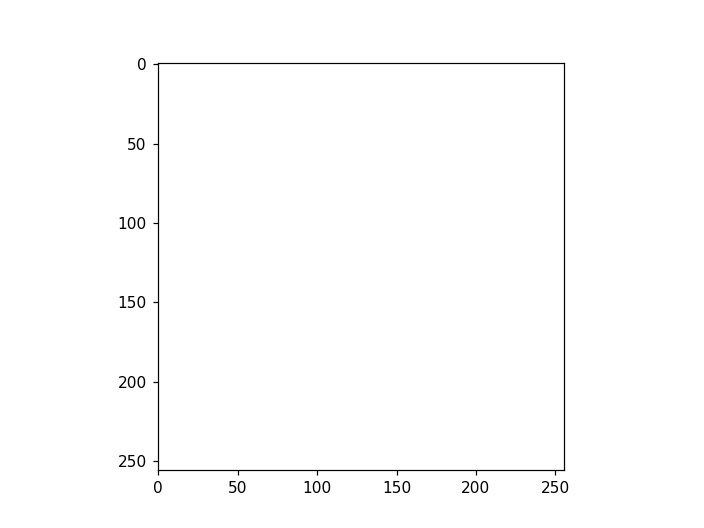

In [12]:
env = gym.make('FrozenLake-v1')
env.reset()

fig, ax = plt.subplots()
#img = ax.imshow(env.render("rgb_array"))
#ims = [img]
ims = []

for _ in range(50):
    
    # Take next action randomly
    action = env.action_space.sample()
    env.step(action)
    
    # Build the image and append to list
    img= ax.imshow(env.render('rgb_array'), animated = True)
    ims.append([img])


ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
env.close()
plt.show()
    

In [13]:
ani.save("FrozenLake_ani_test.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


#### Frozen Lake Test

<IPython.core.display.Javascript object>


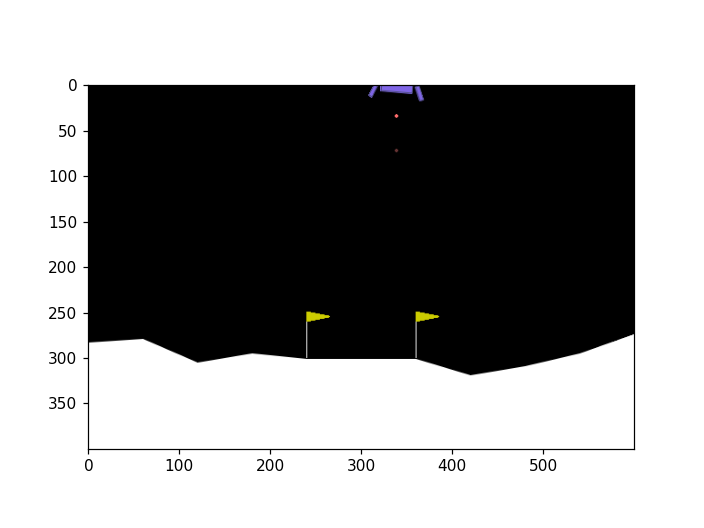

In [11]:
###############
## IMPORTANT ##
###############
# import matplotlib animation and gym

# Make the environment
env = gym.make('LunarLander-v2')
env.reset()

# Doesn't seem relevant
#img = plt.imshow(lunland.render('rgb_array')) # should be called once only

fig, ax = plt.subplots()
#img = ax.imshow(env.render("rgb_array"))
#ims = [img]
ims = []

for _ in range(50):
    
    # Take next action randomly
    action = env.action_space.sample()
    env.step(action)
    
    # Build the image and append to list
    img= ax.imshow(env.render('rgb_array'), animated = True)
    ims.append([img])


ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
env.close()
plt.show()


In [ ]:
ani.save("lunar_ani_test.gif")

#### Tests for cont. vs discrete action spaces

This comes up in the implementation of the agent class
* If action space is discrete, we'll need the number of actions
* If action space is continuous, we'll need the action interval

In [3]:
# Env. with Discrete action space
lunland = gym.make('LunarLander-v2')
lunland.reset()

array([-0.00797939,  1.4094527 , -0.8082508 , -0.06524621,  0.009253  ,
        0.18308091,  0.        ,  0.        ], dtype=float32)

In [4]:
lunland.action_space

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Discrete(4)

In [6]:
help(lunland.unwrapped)

Help on LunarLander in module gym.envs.box2d.lunar_lander object:

class LunarLander(gym.core.Env, gym.utils.ezpickle.EzPickle)
 |  LunarLander(*args, **kwds)
 |  
 |  ### Description
 |  This environment is a classic rocket trajectory optimization problem.
 |  According to Pontryagin's maximum principle, it is optimal to fire the
 |  engine at full throttle or turn it off. This is the reason why this
 |  environment has discrete actions: engine on or off.
 |  
 |  There are two environment versions: discrete or continuous.
 |  The landing pad is always at coordinates (0,0). The coordinates are the
 |  first two numbers in the state vector.
 |  Landing outside of the landing pad is possible. Fuel is infinite, so an agent
 |  can learn to fly and then land on its first attempt.
 |  
 |  To see a heuristic landing, run:
 |  ```
 |  python gym/envs/box2d/lunar_lander.py
 |  ```
 |  <!-- To play yourself, run: -->
 |  <!-- python examples/agents/keyboard_agent.py LunarLander-v2 -->
 |  
 |

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
lunland.unwrapped.observation_space

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Box(-inf, inf, (8,), float32)

In [8]:
lunland.unwrapped.action_space.n

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4

In [9]:
help(gym.envs)

Help on package gym.envs in gym:

NAME
    gym.envs

PACKAGE CONTENTS
    __relocated__
    box2d (package)
    classic_control (package)
    mujoco (package)
    registration
    toy_text (package)

DATA
    registry = ├──CartPole: [ v0, v1 ]
    ├──MountainCar: [ v0 ]
    ├...─Humanoi...

FILE
    c:\programdata\anaconda3\lib\site-packages\gym\envs\__init__.py




In [10]:
# Env. with Continuous action space
cont_mountain_car = gym.make('MountainCarContinuous-v0')
cont_mountain_car.reset()

array([-0.50407547,  0.        ], dtype=float32)

In [11]:
cont_mountain_car.render()

True

In [12]:
cont_mountain_car.close()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
cont_mountain_car.unwrapped.action_space

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Box(-1.0, 1.0, (1,), float32)

In [22]:
cont_mountain_car.action_space.high

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([1.], dtype=float32)

In [23]:
lst = [i for i in range(10)]
print(lst)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
